# Librerías necesarias

In [ ]:
!pip install -r requirements.txt
!pip install utils.py

In [ ]:
import random
import numpy as np
import pandas as pd
from collections import Counter # Exploración
from nltk import ngrams # Exploración
from nltk.probability import FreqDist # Exploración
from stop_words import get_stop_words # Preprocesado
import unicodedata # Preprocesado
import re # Preprocesado
import gzip


from sklearn.model_selection import train_test_split # Modelado
from sklearn.pipeline import Pipeline # Modelado
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # Modelado
from sklearn.feature_selection import chi2 # Reporte
from sklearn.linear_model import LogisticRegression # Reporte
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve # Reporte

import matplotlib.pyplot as plt

# Carga de datos
Se descargan los datos directamente del enlace sugerido en el archivo 'Práctica final NLP'. Se seleccionan los datos del 2018 para la categoría de CD's and Vinyl.

Se descargarán 80.000 registros en total. Cierto es que la cantidad de registros es superior a lo sugerido por la profesora, sin embargo, me gustaría en un enfoque inicial comprobar que los resultados que se obtienen de los modelos sea mejor. A posteriori, y siempre que el tiempo me lo permita, me gustaría hacer comparativas de los resultados, por ejemplo, de los mismos modelos pero contando con la mitad de los registros (20.000 registros).

Además, se ha hecho un balanceo partiendo de los registros originales (+1M) se han seleccionado 40.000 registros para cada resultado (1, 2, 4 y 5 estrellas). Es otra de las asumpciones iniciales, las reviews neutras han sido eliminadas para simplificar el desarrollo de la práctica.

Actualización: Se tiene que disminuir a 10 veces menos el nº de registros seleccionados porque está dando problemas al ejecutar en colab... es decir, total registros 8.000.

In [ ]:
! wget https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz

--2024-06-30 18:52:37--  https://datarepo.eng.ucsd.edu/mcauley_group/data/amazon_v2/categoryFilesSmall/CDs_and_Vinyl_5.json.gz
Resolving datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)... 132.239.8.30
Connecting to datarepo.eng.ucsd.edu (datarepo.eng.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 484144315 (462M) [application/x-gzip]
Saving to: ‘CDs_and_Vinyl_5.json.gz’

CDs_and_Vinyl_5.jso 100%[===================>] 461.72M  21.4MB/s    in 27s     

2024-06-30 18:53:05 (16.9 MB/s) - ‘CDs_and_Vinyl_5.json.gz’ saved [484144315/484144315]



In [ ]:
with gzip.open('CDs_and_Vinyl_5.json.gz', 'rb') as f:
  df = pd.read_json(f,lines=True)

df_flt = df[df['overall'].isin([1,2,3,4,5])]

n_samples = 2000
df_samples_1 = df_flt[df_flt['overall']==1].sample(n=n_samples)
df_samples_2 = df_flt[df_flt['overall']==2].sample(n=n_samples)
df_samples_4 = df_flt[df_flt['overall']==4].sample(n=n_samples)
df_samples_5 = df_flt[df_flt['overall']==5].sample(n=n_samples)

df_rslt = pd.concat([df_samples_1,df_samples_2,df_samples_4,df_samples_5])

df_rslt.to_csv('cds_&_vinyl_smpl.csv', index=False)


In [ ]:
df_rslt.sample(n=1)

,reviewerID,asin,reviewerName,verified,reviewText,overall,reviewTime,summary,unixReviewTime,style,vote,image
901859,A2RTA0NCGYGCFC,B004BCO6YY,S. Desharnais,True,"I really, really love Iron and Wine. When I li...",1,"07 11, 2011",I hate to do this,1310342400,{'Format:': ' Audio CD'},12,NaN


In [ ]:
df_rslt = df_rslt[['reviewText','overall']]

In [ ]:
df_rslt.to_csv('cds_&_vinyl_smplcln.csv', index=False)

In [ ]:
df_rslt.sample(n=1)

,reviewText,overall
1027384,"Prime Cuts: Lord Im Ready Now, Need You Now (W...",4


In [ ]:
df_rslt.shape

(8000, 2)

En este punto se verifica que el resultado final se parece a lo comentado al principio de este apartado, es decir, nos hemos quedado con un data frame de 8.000 registros, balanceado, con reviews positivo y negativos, limpio de otras columnas que no sean la review en sí misma y su valoración.

# Análisis Exploratorio

In [ ]:
import pandas as pd

df = pd.read_csv("/content/cds_&_vinyl_smplcln.csv", index_col = None)

In [ ]:
df.head()

,reviewText,overall
0,What happened?????? They were so good back in ...,1
1,"Thanks to people like Curtis ""I been shot 9 ti...",1
2,dont waste your bucks .. its poor poor po...,1
3,the worst female performer ever seen with shri...,1
4,What happened to the days when you could liste...,1


Toca verificar que la distribución de las reviews sea la esperada después de haber hecho el equilibrio entre ellas.

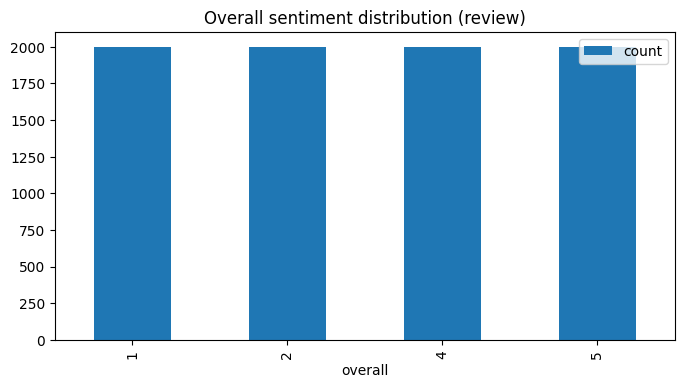

In [ ]:
aux_df = pd.DataFrame(df['overall'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Overall sentiment distribution (review)', figsize=(8, 4))

In [ ]:
def label_sentiment(row):
    if int(row['overall']) < 3:
        return 0
    else:
        return 1

In [ ]:
df['overall_binary'] = df.apply(lambda row: label_sentiment(row), axis=1)

In [ ]:
df.tail()

,reviewText,overall,overall_binary
7995,Thank you.,5,1
7996,Now finally available a new superb 3 CD set on...,5,1
7997,What is there to say. You like Nirvana or you ...,5,1
7998,All is ok,5,1
7999,This CD combines two of Roland Kirk's most cel...,5,1


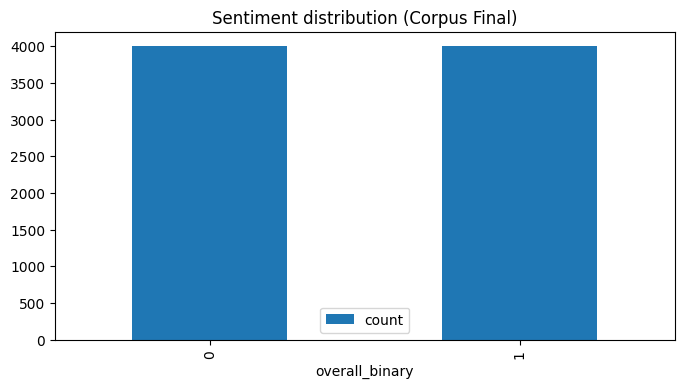

In [ ]:
aux_df = pd.DataFrame(df['overall_binary'].value_counts(sort=False).sort_index())
aux_df = aux_df.plot(kind='bar', title='Sentiment distribution (Corpus Final)', figsize=(8, 4))

In [ ]:
df.to_csv('cds_&_vinyl_expl_done.csv', index=False)

# N-grams más frecuentes

Realizamos el cálculo de los 2-gramas y 3-grams directamente de la Series de pandas con todas las palabras.
Como se observará en los resultados, los N-gram más frecuentes no tienen un impacto en cuanto al análisis de sentimiento se refiere por lo que será necesario limpiar el texto haciendo uso de Stopwords para su análisis.

In [ ]:
splitted_reviews = df['reviewText'].str.lower().str.split()

In [ ]:
words = splitted_reviews.apply(pd.Series).stack().reset_index(drop = True)

In [ ]:
vocabulary_ = Counter(words)
len(vocabulary_)

87565

In [ ]:
bigrams_ = ngrams(words, 2)
trigrams_ = ngrams(words, 3)

In [ ]:
bigrams_freq_ = FreqDist(bigrams_)
trigrams_freq_ = FreqDist(trigrams_)

Parece evidente que la eliminación de stopwords es necesaria.

In [ ]:
bigrams_freq_.most_common(10)

[(('of', 'the'), 6614),
 (('in', 'the'), 3211),
 (('is', 'a'), 2901),
 (('this', 'is'), 2607),
 (('on', 'the'), 2474),
 (('this', 'album'), 2333),
 (('to', 'the'), 2275),
 (('and', 'the'), 2110),
 (('one', 'of'), 1735),
 (('to', 'be'), 1645)]

In [ ]:
trigrams_freq_.most_common(10)


[(('one', 'of', 'the'), 970),
 (('this', 'is', 'a'), 615),
 (('this', 'album', 'is'), 604),
 (('some', 'of', 'the'), 455),
 (('a', 'lot', 'of'), 429),
 (('is', 'one', 'of'), 420),
 (('the', 'rest', 'of'), 363),
 (('of', 'the', 'songs'), 332),
 (('this', 'is', 'the'), 317),
 (('this', 'cd', 'is'), 277)]

#WordCloud
A continuación, se hará una representación utilizando la herramienta WordCloud para ver las palabras más utilizadas para cada una de las categoría de reviews: positivas y negativas.

In [ ]:
!pip install wordcloud

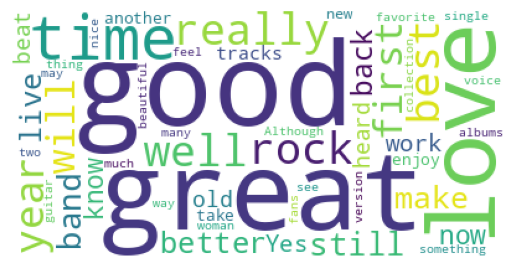

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

sentiment = 1 #positive

# Combinamos las reviews para el sentimiento deseado
combined_text = ''
for text in df[df['overall_binary']==sentiment]['reviewText']:
  if len(combined_text) < 50000:
    combined_text += text

# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para incluir palabras comunes del tema
        stopwords = STOPWORDS.update(['CD','album','track','one','song','songs','fan','end','music','sound']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

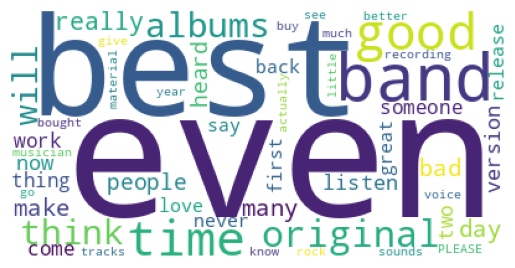

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

sentiment = 0 #negative

# Combinamos las reviews para el sentimiento deseado
combined_text = ''
for text in df[df['overall_binary']==sentiment]['reviewText']:
  if len(combined_text) < 50000:
    combined_text += text

# Inicializamos el wordcloud
wc = WordCloud(background_color='white', max_words=50,
        # Actualizamos las stopwords para incluir palabras comunes del tema
        stopwords = STOPWORDS.update(['CD','album','track','one','song','songs','fan','end','music','sound']))

plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

#Ley de Zipf
Por último, en esta parte de exploración, se hará la visualización de la Ley de Zipf para comprobar que se cumple la distribución logarítmica de la frecuencia de las palabras.

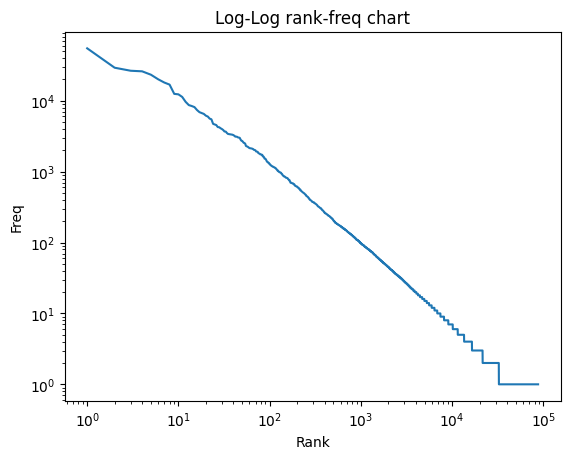

In [ ]:
import matplotlib.pyplot as plt
from nltk.probability import FreqDist

fd = FreqDist(words)
fd = {k: v for k, v in sorted(fd.items(), key=lambda item: item[1], reverse=True)}

ranks = list()
freqs = list()
for rank, word in enumerate(fd):
    ranks.append(rank+1)
    freqs.append(fd[word])

plt.loglog(ranks, freqs)
plt.xlabel('Rank')
plt.ylabel('Freq')
plt.title('Log-Log rank-freq chart')
plt.show()